In [ ]:
!pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 7.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from pandas import read_excel
import numpy as np
import re
from re import sub
import multiprocessing
from unidecode import unidecode
import os
from time import time 
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Activation,Embedding,Flatten,Bidirectional,MaxPooling2D, Conv1D, MaxPooling1D
from keras.optimizers import SGD,Adam
from keras import regularizers
from keras.preprocessing.text import Tokenizer
#from keras_preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
import h5py
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
def text_to_word_list(text):
    text = text.split()
    return text

def replace_strings(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\u00C0-\u017F"          #latin
                           u"\u2000-\u206F"          #generalPunctuations
                               
                           "]+", flags=re.UNICODE)
    english_pattern=re.compile('[a-zA-Z0-9]+', flags=re.I)
    #latin_pattern=re.compile('[A-Za-z\u00C0-\u00D6\u00D8-\u00f6\u00f8-\u00ff\s]*',)
    
    text=emoji_pattern.sub(r'', text)
    text=english_pattern.sub(r'', text)

    return text

def remove_punctuations(my_str):
    # define punctuation
    punctuations = '''````£|¢|Ñ+-*/=EROero৳০১২৩৪৫৬৭৮৯012–34567•89।!()-[]{};:'"“\’,<>./?@#$%^&*_~‘—॥”‰⚽️✌�￰৷￰'''
    
    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct = no_punct + char

    # display the unpunctuated string
    return no_punct

def joining(text):
    out=' '.join(text)
    return out

def preprocessing(text):
    out=remove_punctuations(replace_strings(text))
    return out

In [ ]:
original_samples = pd.read_csv('/gdrive/MyDrive/pr/unbalanced.csv')

In [ ]:
labeled_data_after_second_round = pd.read_csv('/gdrive/MyDrive/pr/labeled_data_after_secondround.csv',sep='\t')
labeled_data_thirdround = pd.read_csv('/gdrive/MyDrive/pr/labeled_data_thirdround.csv',sep='\t')

In [ ]:
labeled_data_after_second_round.drop(labeled_data_after_second_round.columns[[0]], axis = 1, inplace = True)

In [ ]:
labeled_data_thirdround.drop(labeled_data_thirdround.columns[[0]], axis = 1, inplace = True)

In [ ]:
labeled_data_after_second_round

,ID,Texts,labels
0,1,জনগণের ভোট চুরি করে ক্ষমতায় আসা ওই নিয়ত আমাদ...,non_depressive
1,2,সবথেকে বড় যুদ্ধ হলো নিজের মনের সাথে যুদ্ধ আবেগ,non_depressive
2,3,তোমাকে মনে পড়বে যখনিই জ্যোস্না হাসে তোমাকে মন...,non_depressive
3,4,রোজ আকাশে একটা তারা জলমল করতো হাজার মেঘলা এমনক...,non_depressive
4,5,আল্লাহ মহাপরাক্রমশালী এবং সবার ওপর পরিপূর্ণরূপ...,non_depressive
...,...,...,...
1351,3898,আসল অপরাধী ঐ শাজাহান সহ কর্তাব্যক্তিদের । আদতে...,depressive
1352,3899,সুষ্ঠ এবং নির্ভেজাল নির্বাচন দেখতে চান তাইলে ব...,depressive
1353,3900,"ঘণ্টাখানেক সঙ্গে সুমন , সন্ধে ৭ । বিষয় রাতারা...",depressive
1354,3902,"১৫ কেন্দ্রে জাল ভোট , বিএনপির দাবি ৪১ :",non_depressive


In [ ]:
labeled_data_thirdround

,ID,Texts,labels
0,1000,"হ্যালো ফ্রেন্ডস আমি দিশা , সবার নাকাব মুভি টা ...",non_depressive
1,1121,যে কাজ করলে মান বেড়ে যাবে পাপ মিটে যাবে । আব্...,non_depressive
2,1206,কোনো পরিকল্পনা ছাড়াই জীবনের মূল্যবান সময়গুলো...,depressive
3,1209,ওহ ! কোন ছেলেটা যে ক্রাশ খেলো লেখলো প্রেমের না...,depressive
4,1249,নিজেকে কখনো অপদার্থ ভেবে থামিয়ে রেখো না ! কার...,non_depressive
...,...,...,...
120,3698,মেঘলা দিনের ঠান্ডা হাওয়া রিমঝিম বৃষ্টির বেলা ...,non_depressive
121,3703,"ছেলেটি ভাল থেকে হঠ্যাৎ মাথা নষ্ট হয়ে গেছে , প...",non_depressive
122,3755,শাওন রাতে যদি স্বরণে আসে মোরে,non_depressive
123,3854,স্বার্থক জন্ম আমরা জন্মেছি এই দেশে রাস্তায় মা...,depressive


In [ ]:
all_labeled = pd.DataFrame()

In [ ]:
all_labeled = pd.concat([labeled_data_after_second_round, labeled_data_thirdround])

In [ ]:
all_labeled

,ID,Texts,labels
0,1,জনগণের ভোট চুরি করে ক্ষমতায় আসা ওই নিয়ত আমাদ...,non_depressive
1,2,সবথেকে বড় যুদ্ধ হলো নিজের মনের সাথে যুদ্ধ আবেগ,non_depressive
2,3,তোমাকে মনে পড়বে যখনিই জ্যোস্না হাসে তোমাকে মন...,non_depressive
3,4,রোজ আকাশে একটা তারা জলমল করতো হাজার মেঘলা এমনক...,non_depressive
4,5,আল্লাহ মহাপরাক্রমশালী এবং সবার ওপর পরিপূর্ণরূপ...,non_depressive
...,...,...,...
120,3698,মেঘলা দিনের ঠান্ডা হাওয়া রিমঝিম বৃষ্টির বেলা ...,non_depressive
121,3703,"ছেলেটি ভাল থেকে হঠ্যাৎ মাথা নষ্ট হয়ে গেছে , প...",non_depressive
122,3755,শাওন রাতে যদি স্বরণে আসে মোরে,non_depressive
123,3854,স্বার্থক জন্ম আমরা জন্মেছি এই দেশে রাস্তায় মা...,depressive


In [ ]:
unlabeled_remained = original_samples.loc[~original_samples['ID'].isin(all_labeled['ID'])]

In [ ]:
unlabeled_remained

,ID,Texts,labels
1000,1001,কখনো আয়নার সামনে দাঁড়িয়ে নিজের প্রেমে পড়েছ...,depressive
1001,1002,মনের বিরুদ্ধে গিয়ে কোন কাজ করলে সফল হওয়ার চা...,non_depressive
1002,1003,"সব ভালোবাসা প্রেম নয় , কিছু ভালোবাসা বন্ধুত্ব...",non_depressive
1003,1004,"অন্যায় যখন সীমা ছাড়ায় , প্রতিবাদ তখন করতেই ...",non_depressive
1004,1005,কিসের যেন একটা অভাব দেহের ভিতর বসবাস করছে । মা...,depressive
...,...,...,...
3908,3909,দুনিয়ায় যত অনুপ্রবেশকারী তড়িপার দেশদ্রোহী আ...,non_depressive
3909,3910,বরিশাল সিটি কর্পোরেশন নির্বাচনে জালভোটের প্রতি...,non_depressive
3911,3912,ছবিটাতে অনেক কিছু বুঝিয়ে দিলো । পশু হলেও তার ...,non_depressive
3912,3913,পৃথিবীতে নিজেকে নিয়ে গর্ব করার কিছু নেই সব গর...,non_depressive


In [ ]:
all_labeled.reset_index(drop=True)

,ID,Texts,labels
0,1,জনগণের ভোট চুরি করে ক্ষমতায় আসা ওই নিয়ত আমাদ...,non_depressive
1,2,সবথেকে বড় যুদ্ধ হলো নিজের মনের সাথে যুদ্ধ আবেগ,non_depressive
2,3,তোমাকে মনে পড়বে যখনিই জ্যোস্না হাসে তোমাকে মন...,non_depressive
3,4,রোজ আকাশে একটা তারা জলমল করতো হাজার মেঘলা এমনক...,non_depressive
4,5,আল্লাহ মহাপরাক্রমশালী এবং সবার ওপর পরিপূর্ণরূপ...,non_depressive
...,...,...,...
1476,3698,মেঘলা দিনের ঠান্ডা হাওয়া রিমঝিম বৃষ্টির বেলা ...,non_depressive
1477,3703,"ছেলেটি ভাল থেকে হঠ্যাৎ মাথা নষ্ট হয়ে গেছে , প...",non_depressive
1478,3755,শাওন রাতে যদি স্বরণে আসে মোরে,non_depressive
1479,3854,স্বার্থক জন্ম আমরা জন্মেছি এই দেশে রাস্তায় মা...,depressive


In [ ]:
unlabeled_remained.reset_index(drop=True)

,ID,Texts,labels
0,1001,কখনো আয়নার সামনে দাঁড়িয়ে নিজের প্রেমে পড়েছ...,depressive
1,1002,মনের বিরুদ্ধে গিয়ে কোন কাজ করলে সফল হওয়ার চা...,non_depressive
2,1003,"সব ভালোবাসা প্রেম নয় , কিছু ভালোবাসা বন্ধুত্ব...",non_depressive
3,1004,"অন্যায় যখন সীমা ছাড়ায় , প্রতিবাদ তখন করতেই ...",non_depressive
4,1005,কিসের যেন একটা অভাব দেহের ভিতর বসবাস করছে । মা...,depressive
...,...,...,...
2428,3909,দুনিয়ায় যত অনুপ্রবেশকারী তড়িপার দেশদ্রোহী আ...,non_depressive
2429,3910,বরিশাল সিটি কর্পোরেশন নির্বাচনে জালভোটের প্রতি...,non_depressive
2430,3912,ছবিটাতে অনেক কিছু বুঝিয়ে দিলো । পশু হলেও তার ...,non_depressive
2431,3913,পৃথিবীতে নিজেকে নিয়ে গর্ব করার কিছু নেই সব গর...,non_depressive


In [ ]:
all_labeled['Texts']
all_labeled['labels']

0      non_depressive
1      non_depressive
2      non_depressive
3      non_depressive
4      non_depressive
            ...      
120    non_depressive
121    non_depressive
122    non_depressive
123        depressive
124    non_depressive
Name: labels, Length: 1481, dtype: object

In [ ]:
for i in range(len(all_labeled)):
  if all_labeled['labels'].values[i] =="non_depressive":
    all_labeled['labels'].values[i]=1
  elif all_labeled['labels'].values[i] =="depressive":
    all_labeled['labels'].values[i]=0

In [ ]:
all_labeled

,ID,Texts,labels
0,1,জনগণের ভোট চুরি করে ক্ষমতায় আসা ওই নিয়ত আমাদ...,1
1,2,সবথেকে বড় যুদ্ধ হলো নিজের মনের সাথে যুদ্ধ আবেগ,1
2,3,তোমাকে মনে পড়বে যখনিই জ্যোস্না হাসে তোমাকে মন...,1
3,4,রোজ আকাশে একটা তারা জলমল করতো হাজার মেঘলা এমনক...,1
4,5,আল্লাহ মহাপরাক্রমশালী এবং সবার ওপর পরিপূর্ণরূপ...,1
...,...,...,...
120,3698,মেঘলা দিনের ঠান্ডা হাওয়া রিমঝিম বৃষ্টির বেলা ...,1
121,3703,"ছেলেটি ভাল থেকে হঠ্যাৎ মাথা নষ্ট হয়ে গেছে , প...",1
122,3755,শাওন রাতে যদি স্বরণে আসে মোরে,1
123,3854,স্বার্থক জন্ম আমরা জন্মেছি এই দেশে রাস্তায় মা...,0


In [ ]:
all_labeled['Texts'] = all_labeled.Texts.apply(lambda x: preprocessing(str(x)))
all_labeled.head()

,ID,Texts,labels
0,1,জনগণের ভোট চুরি করে ক্ষমতায় আসা ওই নিয়ত আমাদ...,1
1,2,সবথেকে বড় যুদ্ধ হলো নিজের মনের সাথে যুদ্ধ আবেগ,1
2,3,তোমাকে মনে পড়বে যখনিই জ্যোস্না হাসে তোমাকে মন...,1
3,4,রোজ আকাশে একটা তারা জলমল করতো হাজার মেঘলা এমনক...,1
4,5,আল্লাহ মহাপরাক্রমশালী এবং সবার ওপর পরিপূর্ণরূপ...,1


In [ ]:
data1 =pd.read_excel('/gdrive/MyDrive/pr/stopwords_bangla.xlsx')
stop = data1['words'].tolist()

In [ ]:
def stopwordRemoval(text):    
    x=str(text)
    l=x.split()

    stm=[elem for elem in l if elem not in stop]
    
    out=' '.join(stm)
    
    return str(out)

In [ ]:
all_labeled['Texts'] = all_labeled.Texts.apply(lambda x: stopwordRemoval(str(x)))
all_labeled.head(15)

,ID,Texts,labels
0,1,জনগণের ভোট চুরি ক্ষমতায় নিয়ত আওয়ামী লীগ নেত...,1
1,2,সবথেকে যুদ্ধ মনের সাথে যুদ্ধ আবেগ,1
2,3,তোমাকে পড়বে যখনিই জ্যোস্না হাসে তোমাকে পড়বে ...,1
3,4,রোজ আকাশে একটা জলমল করতো মেঘলা ঘন বর্ষাতেও খুঁ...,1
4,5,আল্লাহ মহাপরাক্রমশালী ওপর পরিপূর্ণরূপে বিজয়ী ...,1
5,6,নিষিদ্ধ পল্লীতে নিষিদ্ধ মানুষের বসবাস থাকলেও স...,1
6,7,কেমন আছেন আশা ভালো আছেন,1
7,8,ধৈর্য্য সফলতা সমস্যা ধৈয্যধারন ক্ষমতা তুলো গোছের,1
8,9,গতকাল হুগলী জেলার রিষড়ার হেস্টিংস জুট মিলের শ...,1
9,10,অভিনন্দন,1


In [ ]:
X = all_labeled["Texts"].values
y = all_labeled["labels"].values
print(y)

[1 1 1 ... 1 0 1]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=2)

In [ ]:
print(y_train[900])

1


In [ ]:
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [ ]:
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

1332
149
1332
149


In [ ]:
import tensorflow as tf
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences
from keras.preprocessing import text, sequence
from keras import initializers, regularizers, constraints, optimizers, layers
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, Input, Sequential
from keras.layers import Dense, Input, LSTM, SimpleRNN, Embedding, Dropout, SpatialDropout1D, Activation, Conv1D,GRU
from keras.layers import Conv1D, Bidirectional, GlobalMaxPool1D, MaxPooling1D, BatchNormalization, Add, Flatten
from keras.layers import GlobalMaxPooling1D, GlobalAveragePooling1D, concatenate, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from sklearn import svm
from keras.utils.vis_utils import plot_model

In [ ]:
test_ck = pd.DataFrame(X_train)
test_ck.columns = ["Response"]

length_of_the_messages = test_ck["Response"].str.split("\\s+")


print("Max number of words = ", length_of_the_messages.str.len().max())
print("Index = ", length_of_the_messages.str.len().idxmax())

Max number of words =  42
Index =  269


In [ ]:
num_words = 20000 #Max. words to use per comment
max_features = 60000 #Max. number of unique words in embeddinbg vector
max_len = 64 #Max. number of words per toxic comment to be use
embedding_dims = 64 #embedding vector output dimension 
num_epochs = 100 # (before 5)number of epochs (number of times that the model is exposed to the training dataset)
val_split = 0.05
batch_size2 = 32

In [ ]:
tokenizer = tokenizer = Tokenizer(num_words)
tokenizer.fit_on_texts(X_train)

#Convert tokenized commnent to sequnces
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
 
# padding the sequences
X_train = pad_sequences(X_train, max_len, padding='post')
X_test  = pad_sequences(X_test,  max_len, padding='post')

print('X_train shape:', X_train.shape)
print('X_test shape: ', X_test.shape)

X_train shape: (1332, 64)
X_test shape:  (149, 64)


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size =0.95, random_state=233)

In [ ]:
early = EarlyStopping(monitor="val_loss", mode="min", patience=8)

In [ ]:
#GLoVE Loading
glove_file = open('/gdrive/MyDrive/pr/bn_glove.39M.300d.txt', encoding="utf8")
embeddings_index = dict()
for line in glove_file:
    val = line.split(' ')
    word = val[0]
    coefs = np.asarray(val[1:], dtype='float32')
    embeddings_index[word] = coefs
glove_file.close()

print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 178153 word vectors.


In [ ]:
print(len(tokenizer.word_index)+1)

6245


In [ ]:
embedding_matrix = np.zeros((len(tokenizer.word_index)+1, 300))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape[0]

6245

In [ ]:
LSTM_model = Sequential([
    Embedding(input_dim =embedding_matrix.shape[0], input_length=max_len, output_dim=embedding_matrix.shape[1],weights=[embedding_matrix], trainable=False),
    #So, using this feature will enable the model to look at the context on both the left and the right.
    LSTM(64, return_sequences=True),
    #**batch normalization layer** normalizes the activations of the previous layer at each batch, 
    #i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1. 
    GlobalMaxPool1D(),
    Dense(32, activation = 'relu'),
    Dropout(0.1),
    Dense(16, activation = 'relu'),
    Dropout(0.1),
    Dense(2, activation = 'sigmoid')
])

LSTM_model.compile(loss='binary_crossentropy', optimizer=Adam(0.01), metrics=['accuracy'])

In [ ]:
LSTM_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 64, 300)           1873500   
                                                                 
 lstm_3 (LSTM)               (None, 64, 64)            93440     
                                                                 
 global_max_pooling1d_3 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                      

In [ ]:
LSTM_model_fit = LSTM_model.fit(X_train, y_train, batch_size=16, epochs=num_epochs, validation_data=(X_val, y_val), callbacks=[early])

Epoch 1/100
80/80 [==============================] - 7s 49ms/step - loss: 0.6097 - accuracy: 0.6972 - val_loss: 0.5304 - val_accuracy: 0.7313
Epoch 2/100
80/80 [==============================] - 3s 42ms/step - loss: 0.5031 - accuracy: 0.7281 - val_loss: 0.5174 - val_accuracy: 0.7761
Epoch 3/100
80/80 [==============================] - 5s 67ms/step - loss: 0.3769 - accuracy: 0.8285 - val_loss: 0.5207 - val_accuracy: 0.7015
Epoch 4/100
80/80 [==============================] - 3s 42ms/step - loss: 0.2898 - accuracy: 0.8830 - val_loss: 0.6633 - val_accuracy: 0.7015
Epoch 5/100
80/80 [==============================] - 3s 42ms/step - loss: 0.2325 - accuracy: 0.9107 - val_loss: 0.7928 - val_accuracy: 0.6866
Epoch 6/100
80/80 [==============================] - 3s 41ms/step - loss: 0.2097 - accuracy: 0.9217 - val_loss: 0.8664 - val_accuracy: 0.7313
Epoch 7/100
80/80 [==============================] - 5s 65ms/step - loss: 0.1739 - accuracy: 0.9289 - val_loss: 0.9797 - val_accuracy: 0.7463
Epoch 

In [ ]:
pred_lstm = LSTM_model.predict(X_test)

5/5 [==============================] - 1s 23ms/step


In [ ]:
from sklearn.metrics import accuracy_score
pred_round = np.round(pred_lstm)  
score = accuracy_score(y_test,pred_round)
score

0.7583892617449665

In [ ]:
from sklearn.metrics import classification_report
target_names = ['Normal', 'Depression-Indicative']
print(classification_report(y_test, pred_round, target_names=target_names))

                       precision    recall  f1-score   support

               Normal       0.67      0.59      0.62        51
Depression-Indicative       0.80      0.85      0.82        98

            micro avg       0.76      0.76      0.76       149
            macro avg       0.73      0.72      0.72       149
         weighted avg       0.75      0.76      0.75       149
          samples avg       0.76      0.76      0.76       149



In [ ]:
print(np.around(pred_lstm,3))

[[0.15  0.861]
 [0.005 0.996]
 [0.865 0.139]
 [0.75  0.248]
 [0.    1.   ]
 [0.    1.   ]
 [0.72  0.28 ]
 [0.959 0.042]
 [0.    1.   ]
 [0.    1.   ]
 [0.301 0.726]
 [0.958 0.042]
 [0.03  0.975]
 [0.992 0.008]
 [0.002 0.998]
 [0.973 0.027]
 [0.547 0.451]
 [0.694 0.319]
 [0.008 0.993]
 [0.008 0.993]
 [0.004 0.996]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.055 0.95 ]
 [0.001 0.999]
 [0.001 1.   ]
 [0.    1.   ]
 [0.996 0.004]
 [0.463 0.537]
 [0.989 0.011]
 [0.201 0.81 ]
 [0.    1.   ]
 [0.959 0.041]
 [0.    1.   ]
 [0.248 0.76 ]
 [0.    1.   ]
 [0.158 0.859]
 [0.    1.   ]
 [0.    1.   ]
 [0.06  0.938]
 [0.009 0.993]
 [0.    1.   ]
 [0.99  0.01 ]
 [0.    1.   ]
 [0.993 0.007]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.744 0.266]
 [0.    1.   ]
 [0.06  0.95 ]
 [0.    1.   ]
 [0.002 0.998]
 [0.985 0.015]
 [0.001 0.999]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.224 0.795]
 [0.75  0.248]
 [0.    1.   ]
 [0.005 0.995]
 [0.    1.

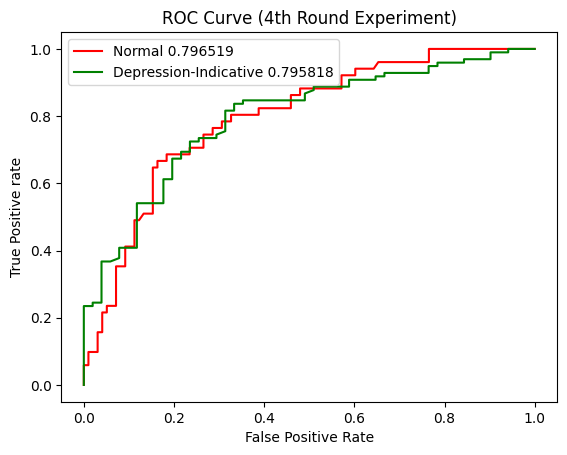

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
roc = {}

n_class = 2

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test.argmax(axis=1), pred_lstm[:,i], pos_label=i)
    roc[i]   = roc_auc_score(y_test[:,i], pred_lstm[:,i], multi_class='ovo')

    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='solid',color='Red', label= 'Normal '+ str(round(roc[0],6)))
plt.plot(fpr[1], tpr[1], linestyle='solid',color='green', label= 'Depression-Indicative '+ str(round(roc[1],6)))



plt.title('ROC Curve (4th Round Experiment)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')

plt.savefig('ROC Curve (4th Round Experiment)',dpi=300);

In [ ]:
unlabeled_texts = unlabeled_remained["Texts"].values
#Convert tokenized commnent to sequnces
unlabeled_texts = tokenizer.texts_to_sequences(unlabeled_texts)

 # padding the sequences
unlabeled_texts = pad_sequences(unlabeled_texts, max_len, padding='post')

In [ ]:
pred_unlabeled = LSTM_model.predict(unlabeled_texts)

77/77 [==============================] - 3s 37ms/step


In [ ]:
print(np.around(pred_unlabeled,3))
print(pred_unlabeled.shape)

[[0.001 0.999]
 [0.    1.   ]
 [0.003 0.997]
 ...
 [0.979 0.021]
 [0.    1.   ]
 [0.993 0.007]]
(2433, 2)


In [ ]:
need_handlabeling = pd.DataFrame(columns=['ID','Texts', 'labels'])

In [ ]:
def least_confi(arr):
      
    # get number of rows and columns
    no_of_rows = arr.shape[0]
    no_of_column = arr.shape[1]
    num_labels = 2 
    cnt = 0;
   
    nh_index = 0
    for i in range(no_of_rows):
          
        # Initialize max1 to 0 at beginning
        # of finding max element of each row
        most_conf = 0
        for j in range(no_of_column):
            if arr[i][j] > most_conf :
                most_conf = arr[i][j]
                numerator = (num_labels * (1 - most_conf))
                denominator = (num_labels - 1)
                least_conf = numerator / denominator

                
                  
        # print maximum element of each row
        print(cnt,".",least_conf)
        
        if(least_conf>0.6): #if the confidence score is greater than 0.6, sample requires handlabeling 
          need_handlabeling.loc[nh_index] = unlabeled_remained.iloc[cnt]
          print("Done")
          nh_index = nh_index + 1
        cnt = cnt+1

In [ ]:
least_confi(pred_unlabeled)

0 . 0.0014346837997436523
1 . 0.0001659393310546875
2 . 0.00547945499420166
3 . 5.4836273193359375e-06
4 . 0.01574838161468506
5 . 0.00012791156768798828
6 . 9.989738464355469e-05
7 . 0.0001685619354248047
8 . 3.8623809814453125e-05
9 . 0.0
10 . 8.702278137207031e-05
11 . 0.03368330001831055
12 . 0.0023638010025024414
13 . 0.003909587860107422
14 . 1.430511474609375e-06
15 . 0.03978776931762695
16 . 0.16817688941955566
17 . 0.018257737159729004
18 . 1.71661376953125e-05
19 . 2.384185791015625e-07
20 . 2.86102294921875e-05
21 . 9.5367431640625e-06
22 . 0.00025022029876708984
23 . 0.0006518363952636719
24 . 0.0
25 . 0.01994800567626953
26 . 1.5616416931152344e-05
27 . 0.00023043155670166016
28 . 0.0
29 . 0.07524526119232178
30 . 1.6689300537109375e-06
31 . 6.4373016357421875e-06
32 . 0.027166008949279785
33 . 3.5762786865234375e-07
34 . 0.00044524669647216797
35 . 0.08188068866729736
36 . 0.05526125431060791
37 . 2.384185791015625e-07
38 . 6.628036499023438e-05
39 . 0.002749800682067871


In [ ]:
fourth_round_handlabeling = pd.DataFrame()

In [ ]:
fourth_round_handlabeling = original_samples.loc[original_samples['ID'].isin(need_handlabeling['ID'])]

In [ ]:
fourth_round_handlabeling

,ID,Texts,labels
1048,1049,ঘাতক সেই বাস কোম্পানির মালিক নৌমন্ত্রীর শ্যালক...,non_depressive
1070,1071,"সিলেট , রাজশাহী , বরিশালের কবরস্থান গুলোতে আইন...",depressive
1148,1149,আজ আন্তর্জাতিক বাঘ দিবস । আপনি কি বাঘপ্রেমী ? ...,non_depressive
1179,1180,আগামীকাল সিলেটের নির্বাচনে যদি কোনো মৃত ব্যক্ত...,depressive
1193,1194,সম্যক পরিবার,non_depressive
...,...,...,...
3562,3563,কোন একদিন আমার বাসার লোকজন আমি পালিয়ে বিয়ে ক...,depressive
3567,3568,"মধ্য আয়ের দেশে উন্নীত হয়ে , বাংলাদেশ এখন ভাঙ...",depressive
3776,3777,এসো এই মুলুকে লতাপাতায় বেষ্টিত এইঘর খানায় । ...,non_depressive
3854,3855,মেয়েটা আমাকে খুব লাইক করে । মেয়েদের ধর্ম হইল...,non_depressive


In [ ]:
fourth_round_handlabeling.to_csv('fourth_round_handlabeling.csv',sep='\t')

In [ ]:
labeled_data_after_third_round = pd.DataFrame()

In [ ]:
labeled_data_after_third_round = original_samples.loc[original_samples['ID'].isin(all_labeled['ID'])]

In [ ]:
labeled_data_after_third_round

,ID,Texts,labels
0,1,জনগণের ভোট চুরি করে ক্ষমতায় আসা ওই নিয়ত আমাদ...,non_depressive
1,2,সবথেকে বড় যুদ্ধ হলো নিজের মনের সাথে যুদ্ধ আবেগ,non_depressive
2,3,তোমাকে মনে পড়বে যখনিই জ্যোস্না হাসে তোমাকে মন...,non_depressive
3,4,রোজ আকাশে একটা তারা জলমল করতো হাজার মেঘলা এমনক...,non_depressive
4,5,আল্লাহ মহাপরাক্রমশালী এবং সবার ওপর পরিপূর্ণরূপ...,non_depressive
...,...,...,...
3897,3898,আসল অপরাধী ঐ শাজাহান সহ কর্তাব্যক্তিদের । আদতে...,depressive
3898,3899,সুষ্ঠ এবং নির্ভেজাল নির্বাচন দেখতে চান তাইলে ব...,depressive
3899,3900,"ঘণ্টাখানেক সঙ্গে সুমন , সন্ধে ৭ । বিষয় রাতারা...",depressive
3901,3902,"১৫ কেন্দ্রে জাল ভোট , বিএনপির দাবি ৪১ :",non_depressive


In [ ]:
labeled_data_after_third_round.to_csv('labeled_data_after_thirdround.csv',sep='\t')